In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans
import math
import numpy as np

In [ ]:
!wget -O "slavik.png" "https://sun9-66.userapi.com/c855320/v855320526/106ec3/PM9DfU3OTJs.jpg"

--2020-06-09 18:18:30--  https://sun9-66.userapi.com/c855320/v855320526/106ec3/PM9DfU3OTJs.jpg
Resolving sun9-66.userapi.com (sun9-66.userapi.com)... 87.240.185.165
Connecting to sun9-66.userapi.com (sun9-66.userapi.com)|87.240.185.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 295664 (289K) [image/jpeg]
Saving to: ‘slavik.png’

slavik.png          100%[===================>] 288.73K  --.-KB/s    in 0.1s    

2020-06-09 18:18:31 (2.75 MB/s) - ‘slavik.png’ saved [295664/295664]



(1280, 959, 3)


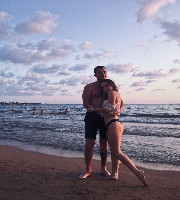

In [ ]:
img = cv2.imread('./slavik.png')
print(img.shape)
img = cv2.resize(img, (180,200))
cv2_imshow(img)

In [ ]:
X = img.reshape(img.shape[0] * img.shape[1],3)
X.shape

(36000, 3)

In [ ]:
X = X/255.

In [ ]:
def getProbability(x, m, E):
  d = x - m
  d = d.reshape(1, 3)
  return (1. / (np.power(2*np.pi, 3/2) * np.linalg.det(E))) * np.exp(-1/2 * np.dot(d, np.linalg.inv(E)).dot(d.T)[0][0])

In [ ]:
X_t = np.array([2, 3, 4]) #проверка работы алгоритма расчитывания значения функции распределения
m_t = np.array([2, 3, 4])
E_t = np.eye(3)
getProbability(X_t, m_t, E_t)

0.06349363593424097

In [ ]:
def new_Parr(X, m, E, w):#вычисление для каждого пикселя вероятность отнесения к одному из класстеров.
  p = []
  z = list(map(list, zip(m, E)))
  for x in X:
    pd = np.array([getProbability(x, m_k, E_k) for m_k, E_k in z]) * w
    pd = pd / np.sum(pd)
    p.append(pd)
  return np.array(p)

In [ ]:
def new_m(P, m, X, w): #P.shape == (N*M, 1), m.shape == (1, k-kluster), X.shape == (N*M, 3), w.shape == (1,)
  m_new = np.zeros(m.shape[0])
  a = P.reshape(1, P.shape[0])
  d = a.dot(X)/w
  return d[0]

In [ ]:
def new_E(P, m, X, w): #P.shape == (N*M, 1), m.shape == (1, k-kluster), X.shape == (N*M, 3), w.shape == (1,)
  a = P.reshape(1, P.shape[0]).T
  matrix = np.tile(a, P.shape[0])
  vec = X - m
  return np.dot(vec.T, matrix).dot(vec)

In [ ]:
kmeans = KMeans(n_clusters=3).fit(X)#быстрый способ получить 3 центра класстера.
m = kmeans.cluster_centers_
E = []
w = []
M = []
for i in range(m.shape[0]):
    E.append(np.eye(m.shape[0]))
E = np.array(E) #наши матрицы ковариаци для каждого кластера
w = np.array([1./3, 1./3, 1./3]) #наши веса

In [ ]:
print(m)
print(E)
print(w)

[[0.25488579 0.21862673 0.26887259]
 [0.68555742 0.58444014 0.56772052]
 [0.85590788 0.7826676  0.77854156]]
[[[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]]
[0.33333333 0.33333333 0.33333333]


In [ ]:
m = np.array([[32, 38, 57], [ 40,  97, 196], [108, 102, 107]])/255

In [ ]:
P = new_Parr(X, m, E, w)
P.shape

(36000, 3)

In [ ]:
def it(X, w, P, E, Lmax, iter):
  Lnew = 5
  while 1 and iter:
    Lmax = Lnew
    m_new = []
    E_new = []
    w = np.sum(P, axis=0)
    for i in range(m.shape[0]):
      m_new.append(new_m(P[:, i], m[i], X, w[i]))
      E_new.append(new_E(P[:, i], m_new[i], X, w[i]))
    m_new = np.array(m_new)
    E_new = np.array(E_new)
    P = new_Parr(X, m, E, w)
    w = np.sum(P, axis=0) / P.shape[0]
    # Lnew = np.sum([-np.log(np.sum(w * x)) for x in P])
    iter -= 1
    # print(Lnew,'is Lnew;', iter, 'is iter')
  return m, E, P

In [ ]:
m = np.array([[32, 38, 57], [ 40,  97, 196], [108, 102, 107]])/255 #задал вручную центры класстера.

In [ ]:
Lmax = np.sum([-np.log(np.sum(w * x)) for x in P])
print(Lmax)
m_1, E_1, P_1 = it(X, w, P, E, Lmax, 12)

In [ ]:
label = []
for p in P:
  label.append(np.argmax(p))
label = np.array(label)
label[label == 0].shape, label[label == 1].shape, label[label == 2].shape 

((9450,), (336,), (26214,))

In [ ]:
new = np.zeros((P.shape[0], 3))
new.shape

(36000, 3)

In [ ]:
for i in range(P.shape[0]):
  if label[i] == 0:
    new[i] += m[0] * 255
  if label[i] == 1:
    new[i] += m[1] * 255
  if label[i] == 2:
    new[i] += m[2] * 255

In [ ]:
img.shape

(200, 180, 3)

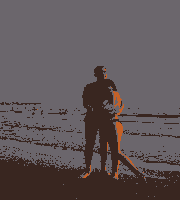

In [ ]:
cv2_imshow(new.reshape(img.shape))

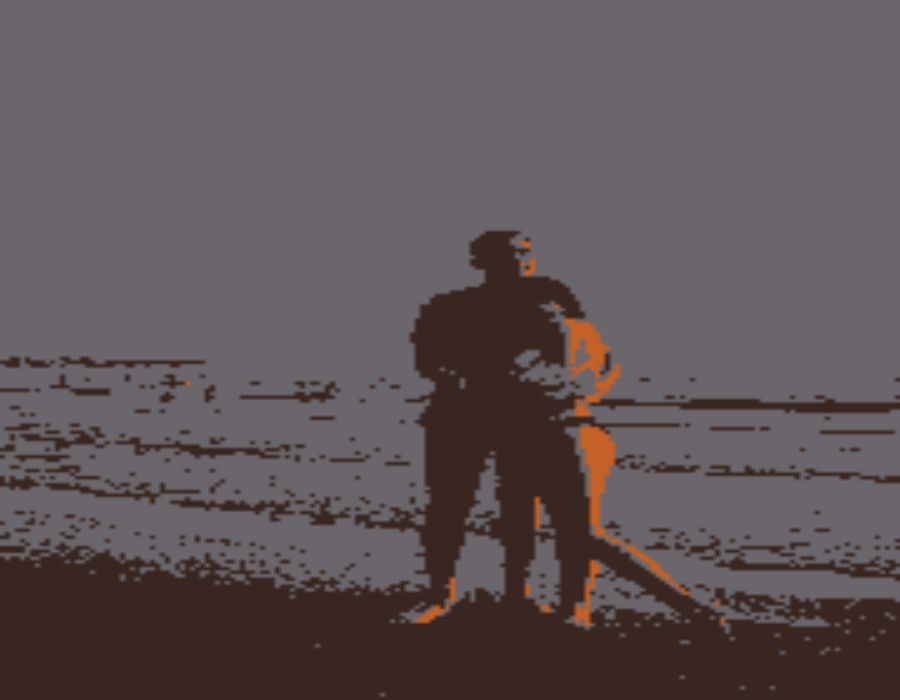

In [ ]:
cv2_imshow(cv2.resize(new.reshape(img.shape), (900, 700)))